In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  

class TabularAugmentation:
    def __init__(self, categorical_cols, numerical_cols):
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols

    def gaussian_noise(self, x, sigma=0.1):
        return x + torch.randn_like(x).to(x.dtype) * sigma

    def feature_dropout(self, x, p=0.1):
        mask = torch.bernoulli(torch.ones_like(x) * (1 - p)).to(x.dtype)
        return x * mask

    def categorical_swap(self, x, swap_prob=0.1):
        """
        x is a 1D tensor of categorical features
        """
        x_new = x.clone()

        # Simple random swap of categorical values
        if torch.rand(1).item() < swap_prob:
            # Randomly shuffle the categorical values
            perm = torch.randperm(len(x))
            x_new = x[perm]

        return x_new

    def __call__(self, x):
        """
        x is a 1D tensor of all features
        """
        # Split features
        x_numerical = x[self.numerical_cols]
        x_categorical = x[self.categorical_cols]

        # First augmentation
        aug1 = x.clone()
        aug1[self.numerical_cols] = self.gaussian_noise(self.feature_dropout(x_numerical))
        aug1[self.categorical_cols] = self.categorical_swap(x_categorical)

        # Second augmentation
        aug2 = x.clone()
        aug2[self.numerical_cols] = self.gaussian_noise(self.feature_dropout(x_numerical))
        aug2[self.categorical_cols] = self.categorical_swap(x_categorical)

        return aug1, aug2


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )
        
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.5):
        super().__init__()
        self.encoder = encoder
        self.temperature = temperature
        
    def info_nce_loss(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        
        sim = torch.mm(z, z.t()) / self.temperature
        sim_i_j = torch.diag(sim, N)
        sim_j_i = torch.diag(sim, -N)
        
        positive_samples = torch.cat([sim_i_j, sim_j_i], dim=0).reshape(N, 2)
        negative_samples = sim[N:,:N]
        
        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat([positive_samples, negative_samples], dim=1)
        
        loss = F.cross_entropy(logits, labels)
        return loss
    
    def forward(self, x_i, x_j):
        z_i = self.encoder(x_i)
        z_j = self.encoder(x_j)
        loss = self.info_nce_loss(z_i, z_j)
        return loss


In [34]:
def prepare_titanic_data(df):
    # Select relevant columns
    categorical_cols = ['Pclass', 'Sex', 'Embarked']
    numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    # Create a copy of selected columns only
    df_selected = df[categorical_cols + numerical_cols].copy()

    # Convert numerical columns to float32
    for col in numerical_cols:
        df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce').astype('float32')
        df_selected[col] = df_selected[col].fillna(df_selected[col].mean())

    # Handle missing values in categorical columns
    for col in categorical_cols:
        df_selected[col] = df_selected[col].fillna(df_selected[col].mode()[0])

    # Convert categorical columns to one-hot
    df_encoded = pd.get_dummies(df_selected, columns=categorical_cols)

    # Convert all columns to float32
    df_encoded = df_encoded.astype('float32')

    # Get indices
    numerical_indices = list(range(len(numerical_cols)))
    categorical_indices = list(range(len(numerical_cols), df_encoded.shape[1]))

    return df_encoded, categorical_indices, numerical_indices

Data shape: (891, 12)
Number of categorical indices: 8
Number of numerical indices: 4
Dataset tensor shape: torch.Size([712, 12])
Dataset tensor shape: torch.Size([179, 12])
Sample input shape: torch.Size([12])


Epoch 1/100: 100%|██████████| 3/3 [00:00<00:00, 20.79it/s]


Epoch 1: Train Loss = 5.2460, Val Loss = 4.6598


Epoch 2/100: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


Epoch 2: Train Loss = 4.7167, Val Loss = 4.1503


Epoch 3/100: 100%|██████████| 3/3 [00:00<00:00, 22.11it/s]


Epoch 3: Train Loss = 4.3460, Val Loss = 3.9417


Epoch 4/100: 100%|██████████| 3/3 [00:00<00:00, 20.90it/s]


Epoch 4: Train Loss = 4.3202, Val Loss = 4.0111


Epoch 5/100: 100%|██████████| 3/3 [00:00<00:00, 20.90it/s]


Epoch 5: Train Loss = 4.3096, Val Loss = 4.0396


Epoch 6/100: 100%|██████████| 3/3 [00:00<00:00, 21.03it/s]


Epoch 6: Train Loss = 4.2607, Val Loss = 3.9063


Epoch 7/100: 100%|██████████| 3/3 [00:00<00:00, 20.73it/s]


Epoch 7: Train Loss = 4.2324, Val Loss = 3.9338


Epoch 8/100: 100%|██████████| 3/3 [00:00<00:00, 20.56it/s]


Epoch 8: Train Loss = 4.1499, Val Loss = 3.9480


Epoch 9/100: 100%|██████████| 3/3 [00:00<00:00, 20.87it/s]


Epoch 9: Train Loss = 4.2615, Val Loss = 3.9213


Epoch 10/100: 100%|██████████| 3/3 [00:00<00:00, 20.87it/s]


Epoch 10: Train Loss = 4.1686, Val Loss = 3.9332


Epoch 11/100: 100%|██████████| 3/3 [00:00<00:00, 20.74it/s]


Epoch 11: Train Loss = 4.1130, Val Loss = 3.8688


Epoch 12/100: 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]


Epoch 12: Train Loss = 4.1669, Val Loss = 3.8866


Epoch 13/100: 100%|██████████| 3/3 [00:00<00:00, 20.85it/s]


Epoch 13: Train Loss = 4.1590, Val Loss = 3.8929


Epoch 14/100: 100%|██████████| 3/3 [00:00<00:00, 21.50it/s]


Epoch 14: Train Loss = 4.1627, Val Loss = 3.8438


Epoch 15/100: 100%|██████████| 3/3 [00:00<00:00, 20.62it/s]


Epoch 15: Train Loss = 4.1664, Val Loss = 3.8284


Epoch 16/100: 100%|██████████| 3/3 [00:00<00:00, 20.58it/s]


Epoch 16: Train Loss = 4.1329, Val Loss = 3.8856


Epoch 17/100: 100%|██████████| 3/3 [00:00<00:00, 20.87it/s]


Epoch 17: Train Loss = 4.1532, Val Loss = 3.8861


Epoch 18/100: 100%|██████████| 3/3 [00:00<00:00, 20.39it/s]


Epoch 18: Train Loss = 4.1534, Val Loss = 3.8317


Epoch 19/100: 100%|██████████| 3/3 [00:00<00:00, 21.61it/s]


Epoch 19: Train Loss = 4.1733, Val Loss = 3.8073


Epoch 20/100: 100%|██████████| 3/3 [00:00<00:00, 20.58it/s]


Epoch 20: Train Loss = 4.1230, Val Loss = 3.8809


Epoch 21/100: 100%|██████████| 3/3 [00:00<00:00, 20.74it/s]


Epoch 21: Train Loss = 4.1592, Val Loss = 3.8756


Epoch 22/100: 100%|██████████| 3/3 [00:00<00:00, 20.37it/s]


Epoch 22: Train Loss = 4.1065, Val Loss = 3.8445


Epoch 23/100: 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]


Epoch 23: Train Loss = 4.0951, Val Loss = 3.8288


Epoch 24/100: 100%|██████████| 3/3 [00:00<00:00, 20.93it/s]


Epoch 24: Train Loss = 4.1006, Val Loss = 3.8592


Epoch 25/100: 100%|██████████| 3/3 [00:00<00:00, 22.28it/s]


Epoch 25: Train Loss = 4.0839, Val Loss = 3.8423


Epoch 26/100: 100%|██████████| 3/3 [00:00<00:00, 20.92it/s]


Epoch 26: Train Loss = 4.0979, Val Loss = 3.8585


Epoch 27/100: 100%|██████████| 3/3 [00:00<00:00, 20.39it/s]


Epoch 27: Train Loss = 4.1356, Val Loss = 3.7740


Epoch 28/100: 100%|██████████| 3/3 [00:00<00:00, 20.80it/s]


Epoch 28: Train Loss = 4.0811, Val Loss = 3.8803


Epoch 29/100: 100%|██████████| 3/3 [00:00<00:00, 21.48it/s]


Epoch 29: Train Loss = 4.0636, Val Loss = 3.8295


Epoch 30/100: 100%|██████████| 3/3 [00:00<00:00, 20.43it/s]


Epoch 30: Train Loss = 4.0698, Val Loss = 3.8559


Epoch 31/100: 100%|██████████| 3/3 [00:00<00:00, 20.74it/s]


Epoch 31: Train Loss = 4.0729, Val Loss = 3.8256


Epoch 32/100: 100%|██████████| 3/3 [00:00<00:00, 20.65it/s]


Epoch 32: Train Loss = 4.0768, Val Loss = 3.8411


Epoch 33/100: 100%|██████████| 3/3 [00:00<00:00, 20.82it/s]


Epoch 33: Train Loss = 4.0325, Val Loss = 3.8394


Epoch 34/100: 100%|██████████| 3/3 [00:00<00:00, 22.11it/s]


Epoch 34: Train Loss = 4.0721, Val Loss = 3.8104


Epoch 35/100: 100%|██████████| 3/3 [00:00<00:00, 20.60it/s]


Epoch 35: Train Loss = 4.0805, Val Loss = 3.8679


Epoch 36/100: 100%|██████████| 3/3 [00:00<00:00, 20.81it/s]


Epoch 36: Train Loss = 4.0751, Val Loss = 3.8204


Epoch 37/100: 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]


Epoch 37: Train Loss = 4.0572, Val Loss = 3.8441


Epoch 38/100: 100%|██████████| 3/3 [00:00<00:00, 21.61it/s]


Epoch 38: Train Loss = 4.0646, Val Loss = 3.8220


Epoch 39/100: 100%|██████████| 3/3 [00:00<00:00, 20.54it/s]


Epoch 39: Train Loss = 4.0960, Val Loss = 3.7997


Epoch 40/100: 100%|██████████| 3/3 [00:00<00:00, 12.63it/s]


Epoch 40: Train Loss = 4.0814, Val Loss = 3.7851


Epoch 41/100: 100%|██████████| 3/3 [00:00<00:00, 19.91it/s]


Epoch 41: Train Loss = 4.0761, Val Loss = 3.8453


Epoch 42/100: 100%|██████████| 3/3 [00:00<00:00, 20.91it/s]


Epoch 42: Train Loss = 4.0818, Val Loss = 3.7527


Epoch 43/100: 100%|██████████| 3/3 [00:00<00:00, 21.01it/s]


Epoch 43: Train Loss = 4.0532, Val Loss = 3.7607


Epoch 44/100: 100%|██████████| 3/3 [00:00<00:00, 21.88it/s]


Epoch 44: Train Loss = 4.0639, Val Loss = 3.7998


Epoch 45/100: 100%|██████████| 3/3 [00:00<00:00, 19.79it/s]


Epoch 45: Train Loss = 4.0891, Val Loss = 3.8477


Epoch 46/100: 100%|██████████| 3/3 [00:00<00:00, 20.06it/s]


Epoch 46: Train Loss = 4.0802, Val Loss = 3.8512


Epoch 47/100: 100%|██████████| 3/3 [00:00<00:00, 20.41it/s]


Epoch 47: Train Loss = 4.0545, Val Loss = 3.8152


Epoch 48/100: 100%|██████████| 3/3 [00:00<00:00, 21.78it/s]


Epoch 48: Train Loss = 4.0529, Val Loss = 3.8048


Epoch 49/100: 100%|██████████| 3/3 [00:00<00:00, 19.32it/s]


Epoch 49: Train Loss = 4.1153, Val Loss = 3.7691


Epoch 50/100: 100%|██████████| 3/3 [00:00<00:00, 20.61it/s]


Epoch 50: Train Loss = 4.0264, Val Loss = 3.8499


Epoch 51/100: 100%|██████████| 3/3 [00:00<00:00, 21.09it/s]


Epoch 51: Train Loss = 4.0629, Val Loss = 3.7648


Epoch 52/100: 100%|██████████| 3/3 [00:00<00:00, 19.89it/s]


Epoch 52: Train Loss = 4.0729, Val Loss = 3.8706


Epoch 53/100: 100%|██████████| 3/3 [00:00<00:00, 19.54it/s]


Epoch 53: Train Loss = 4.0847, Val Loss = 3.7571


Epoch 54/100: 100%|██████████| 3/3 [00:00<00:00, 20.38it/s]


Epoch 54: Train Loss = 4.1049, Val Loss = 3.7722


Epoch 55/100: 100%|██████████| 3/3 [00:00<00:00, 21.08it/s]


Epoch 55: Train Loss = 4.0589, Val Loss = 3.7619


Epoch 56/100: 100%|██████████| 3/3 [00:00<00:00, 19.27it/s]


Epoch 56: Train Loss = 4.0124, Val Loss = 3.8171


Epoch 57/100: 100%|██████████| 3/3 [00:00<00:00, 19.75it/s]


Epoch 57: Train Loss = 4.0717, Val Loss = 3.7735


Epoch 58/100: 100%|██████████| 3/3 [00:00<00:00, 20.66it/s]


Epoch 58: Train Loss = 4.0959, Val Loss = 3.8084


Epoch 59/100: 100%|██████████| 3/3 [00:00<00:00, 20.25it/s]


Epoch 59: Train Loss = 4.0403, Val Loss = 3.7876


Epoch 60/100: 100%|██████████| 3/3 [00:00<00:00, 20.10it/s]


Epoch 60: Train Loss = 4.0290, Val Loss = 3.8090


Epoch 61/100: 100%|██████████| 3/3 [00:00<00:00, 20.63it/s]


Epoch 61: Train Loss = 4.0528, Val Loss = 3.7983


Epoch 62/100: 100%|██████████| 3/3 [00:00<00:00, 21.48it/s]


Epoch 62: Train Loss = 4.0707, Val Loss = 3.8003


Epoch 63/100: 100%|██████████| 3/3 [00:00<00:00, 19.81it/s]


Epoch 63: Train Loss = 4.0234, Val Loss = 3.7861


Epoch 64/100: 100%|██████████| 3/3 [00:00<00:00, 20.57it/s]


Epoch 64: Train Loss = 4.0115, Val Loss = 3.7314


Epoch 65/100: 100%|██████████| 3/3 [00:00<00:00, 20.97it/s]


Epoch 65: Train Loss = 4.0153, Val Loss = 3.8273


Epoch 66/100: 100%|██████████| 3/3 [00:00<00:00, 19.18it/s]


Epoch 66: Train Loss = 4.0504, Val Loss = 3.7532


Epoch 67/100: 100%|██████████| 3/3 [00:00<00:00, 19.55it/s]


Epoch 67: Train Loss = 4.0640, Val Loss = 3.7784


Epoch 68/100: 100%|██████████| 3/3 [00:00<00:00, 20.19it/s]


Epoch 68: Train Loss = 4.0727, Val Loss = 3.7619


Epoch 69/100: 100%|██████████| 3/3 [00:00<00:00, 20.42it/s]


Epoch 69: Train Loss = 4.0769, Val Loss = 3.7988


Epoch 70/100: 100%|██████████| 3/3 [00:00<00:00, 19.88it/s]


Epoch 70: Train Loss = 4.0441, Val Loss = 3.8311


Epoch 71/100: 100%|██████████| 3/3 [00:00<00:00, 20.30it/s]


Epoch 71: Train Loss = 4.0692, Val Loss = 3.8094


Epoch 72/100: 100%|██████████| 3/3 [00:00<00:00, 20.29it/s]


Epoch 72: Train Loss = 4.0520, Val Loss = 3.8066


Epoch 73/100: 100%|██████████| 3/3 [00:00<00:00, 20.03it/s]


Epoch 73: Train Loss = 4.0298, Val Loss = 3.7417


Epoch 74/100: 100%|██████████| 3/3 [00:00<00:00, 20.31it/s]


Epoch 74: Train Loss = 4.0287, Val Loss = 3.7407


Epoch 75/100: 100%|██████████| 3/3 [00:00<00:00, 20.98it/s]


Epoch 75: Train Loss = 4.0289, Val Loss = 3.8499


Epoch 76/100: 100%|██████████| 3/3 [00:00<00:00, 19.74it/s]


Epoch 76: Train Loss = 4.0204, Val Loss = 3.7749


Epoch 77/100: 100%|██████████| 3/3 [00:00<00:00, 20.45it/s]


Epoch 77: Train Loss = 4.0091, Val Loss = 3.7432


Epoch 78/100: 100%|██████████| 3/3 [00:00<00:00, 20.27it/s]


Epoch 78: Train Loss = 4.0353, Val Loss = 3.7542


Epoch 79/100: 100%|██████████| 3/3 [00:00<00:00, 21.59it/s]


Epoch 79: Train Loss = 4.0334, Val Loss = 3.7556


Epoch 80/100: 100%|██████████| 3/3 [00:00<00:00, 20.20it/s]


Epoch 80: Train Loss = 4.0496, Val Loss = 3.7490


Epoch 81/100: 100%|██████████| 3/3 [00:00<00:00, 21.09it/s]


Epoch 81: Train Loss = 4.0193, Val Loss = 3.7471


Epoch 82/100: 100%|██████████| 3/3 [00:00<00:00, 21.09it/s]


Epoch 82: Train Loss = 4.0565, Val Loss = 3.7952


Epoch 83/100: 100%|██████████| 3/3 [00:00<00:00, 21.86it/s]


Epoch 83: Train Loss = 4.0474, Val Loss = 3.7434


Epoch 84/100: 100%|██████████| 3/3 [00:00<00:00, 21.17it/s]


Epoch 84: Train Loss = 4.0660, Val Loss = 3.8071


Epoch 85/100: 100%|██████████| 3/3 [00:00<00:00, 21.92it/s]


Epoch 85: Train Loss = 4.0451, Val Loss = 3.7282


Epoch 86/100: 100%|██████████| 3/3 [00:00<00:00, 21.89it/s]


Epoch 86: Train Loss = 4.0466, Val Loss = 3.8075


Epoch 87/100: 100%|██████████| 3/3 [00:00<00:00, 21.57it/s]


Epoch 87: Train Loss = 4.0811, Val Loss = 3.7447


Epoch 88/100: 100%|██████████| 3/3 [00:00<00:00, 21.33it/s]


Epoch 88: Train Loss = 3.9934, Val Loss = 3.7746


Epoch 89/100: 100%|██████████| 3/3 [00:00<00:00, 21.63it/s]


Epoch 89: Train Loss = 4.0529, Val Loss = 3.7464


Epoch 90/100: 100%|██████████| 3/3 [00:00<00:00, 20.58it/s]


Epoch 90: Train Loss = 4.0415, Val Loss = 3.7938


Epoch 91/100: 100%|██████████| 3/3 [00:00<00:00, 21.60it/s]


Epoch 91: Train Loss = 4.0131, Val Loss = 3.7810


Epoch 92/100: 100%|██████████| 3/3 [00:00<00:00, 20.97it/s]


Epoch 92: Train Loss = 4.0313, Val Loss = 3.7761


Epoch 93/100: 100%|██████████| 3/3 [00:00<00:00, 20.11it/s]


Epoch 93: Train Loss = 4.0197, Val Loss = 3.7697


Epoch 94/100: 100%|██████████| 3/3 [00:00<00:00, 21.90it/s]


Epoch 94: Train Loss = 4.0452, Val Loss = 3.7870


Epoch 95/100: 100%|██████████| 3/3 [00:00<00:00, 20.66it/s]


Epoch 95: Train Loss = 4.0716, Val Loss = 3.7359


Epoch 96/100: 100%|██████████| 3/3 [00:00<00:00, 21.60it/s]


Epoch 96: Train Loss = 4.0263, Val Loss = 3.7729


Epoch 97/100: 100%|██████████| 3/3 [00:00<00:00, 21.14it/s]


Epoch 97: Train Loss = 4.0540, Val Loss = 3.8019


Epoch 98/100: 100%|██████████| 3/3 [00:00<00:00, 21.90it/s]


Epoch 98: Train Loss = 4.0456, Val Loss = 3.7661


Epoch 99/100: 100%|██████████| 3/3 [00:00<00:00, 20.30it/s]


Epoch 99: Train Loss = 3.9917, Val Loss = 3.7957


Epoch 100/100: 100%|██████████| 3/3 [00:00<00:00, 21.71it/s]


Epoch 100: Train Loss = 4.0078, Val Loss = 3.7790


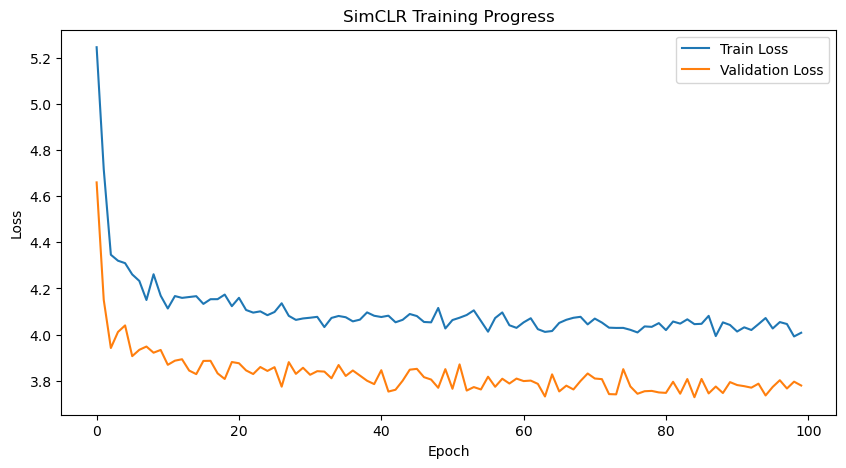

In [35]:
class TitanicDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.FloatTensor(data.values.astype('float32'))
        self.transform = transform

        # Debug print
        print("Dataset tensor shape:", self.data.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # This will be a 1D tensor
        if self.transform:
            x_i, x_j = self.transform(x)
            return x_i, x_j
        return x

def train_simclr(model, train_loader, val_loader, optimizer, num_epochs=100, device="cuda"):
    model = model.to(device)
    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for x_i, x_j in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            x_i, x_j = x_i.to(device), x_j.to(device)
            loss = model(x_i, x_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_i, x_j in val_loader:
                x_i, x_j = x_i.to(device), x_j.to(device)
                loss = model(x_i, x_j)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_simclr_model.pt')

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')

    return train_losses, val_losses

def prepare_data_and_train():
    # Load and preprocess data
    df = pd.read_csv('train.csv')
    df_processed, categorical_indices, numerical_indices = prepare_titanic_data(df)

    # Debug prints
    print("Data shape:", df_processed.shape)
    print("Number of categorical indices:", len(categorical_indices))
    print("Number of numerical indices:", len(numerical_indices))

    # Split data
    train_data, val_data = train_test_split(df_processed, test_size=0.2, random_state=42)

    # Scale numerical features only
    scaler = StandardScaler()
    train_data.iloc[:, numerical_indices] = scaler.fit_transform(train_data.iloc[:, numerical_indices])
    val_data.iloc[:, numerical_indices] = scaler.transform(val_data.iloc[:, numerical_indices])

    # Ensure all data is float32
    train_data = train_data.astype('float32')
    val_data = val_data.astype('float32')

    # Create augmentation
    augmentation = TabularAugmentation(
        categorical_cols=categorical_indices,
        numerical_cols=numerical_indices
    )

    # Create datasets and dataloaders
    train_dataset = TitanicDataset(train_data, transform=augmentation)
    val_dataset = TitanicDataset(val_data, transform=augmentation)

    # Test augmentation
    x_sample = train_dataset[0]
    print("Sample input shape:", x_sample[0].shape)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)

    # Initialize model and optimizer
    input_dim = df_processed.shape[1]
    encoder = Encoder(input_dim=input_dim)
    model = SimCLR(encoder)

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_losses, val_losses = train_simclr(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=100,
        device=device
    )

    return model, train_losses, val_losses

# Run training
model, train_losses, val_losses = prepare_data_and_train()

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('SimCLR Training Progress')
plt.savefig('training_curves.png')
plt.show()


Preparing evaluation data...

Evaluating SimCLR model...
Extracting features...
Feature shapes - Train: (712, 128), Val: (179, 128)

Performing linear probe evaluation...

Linear Probe Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


Generating t-SNE visualization...


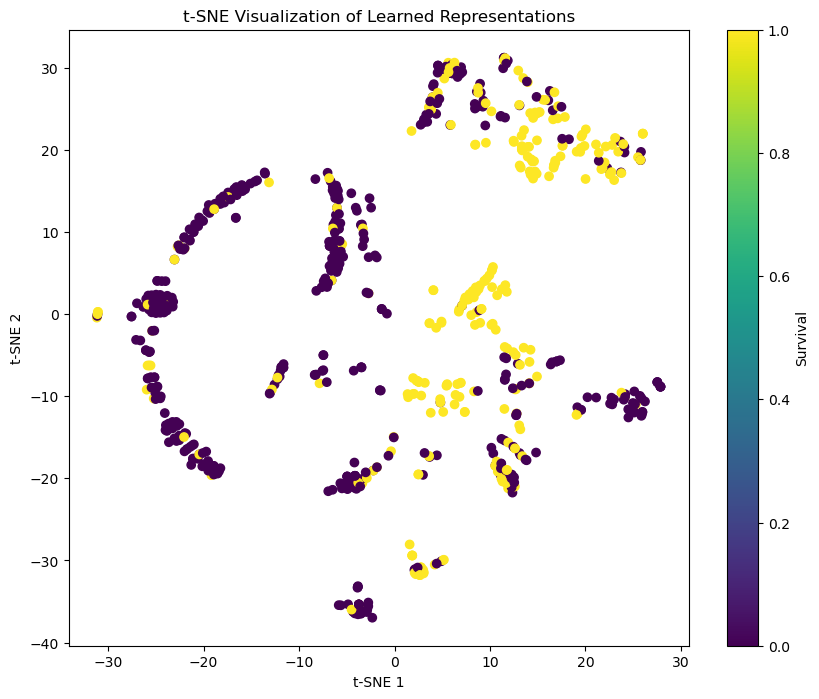


Analyzing feature importance...


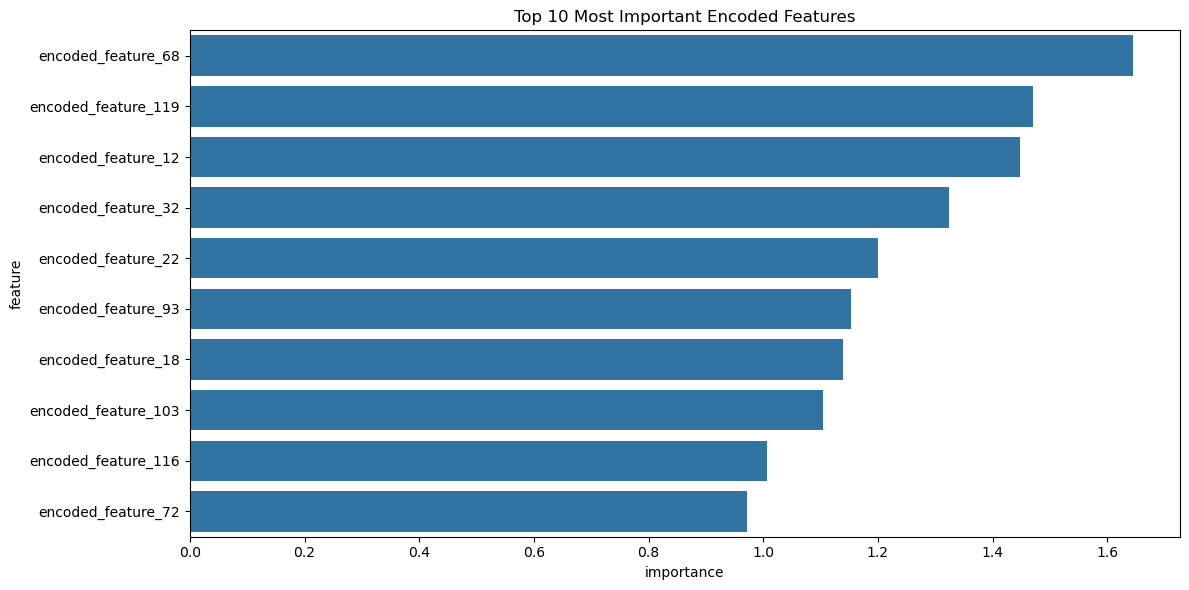


Linear probe accuracy: 0.7989

Top 10 most important encoded features:
                 feature  importance
68    encoded_feature_68    1.644667
119  encoded_feature_119    1.470676
12    encoded_feature_12    1.448355
32    encoded_feature_32    1.324251
22    encoded_feature_22    1.199894
93    encoded_feature_93    1.153463
18    encoded_feature_18    1.138301
103  encoded_feature_103    1.104823
116  encoded_feature_116    1.006489
72    encoded_feature_72    0.971643

Analyzing original feature importance...


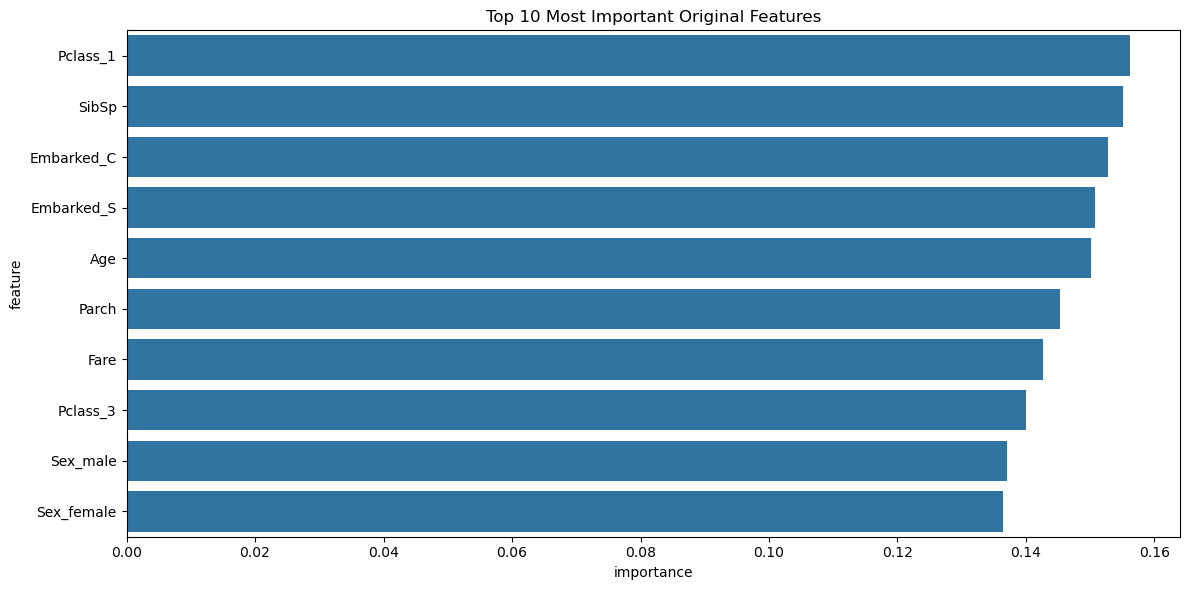


Top 10 most important original features:
       feature  importance
4     Pclass_1    0.156163
1        SibSp    0.155053
9   Embarked_C    0.152815
11  Embarked_S    0.150751
0          Age    0.150158
2        Parch    0.145262
3         Fare    0.142600
6     Pclass_3    0.139982
8     Sex_male    0.137098
7   Sex_female    0.136379

Fine-tuning for survival prediction...
Epoch 1: Train Acc = 60.53%, Val Acc = 69.83%
Epoch 2: Train Acc = 69.52%, Val Acc = 69.83%
Epoch 3: Train Acc = 71.35%, Val Acc = 72.07%
Epoch 4: Train Acc = 73.46%, Val Acc = 74.86%
Epoch 5: Train Acc = 76.26%, Val Acc = 77.09%
Epoch 6: Train Acc = 78.09%, Val Acc = 77.09%
Epoch 7: Train Acc = 79.07%, Val Acc = 77.65%
Epoch 8: Train Acc = 78.37%, Val Acc = 79.33%
Epoch 9: Train Acc = 79.21%, Val Acc = 78.77%
Epoch 10: Train Acc = 78.79%, Val Acc = 79.89%


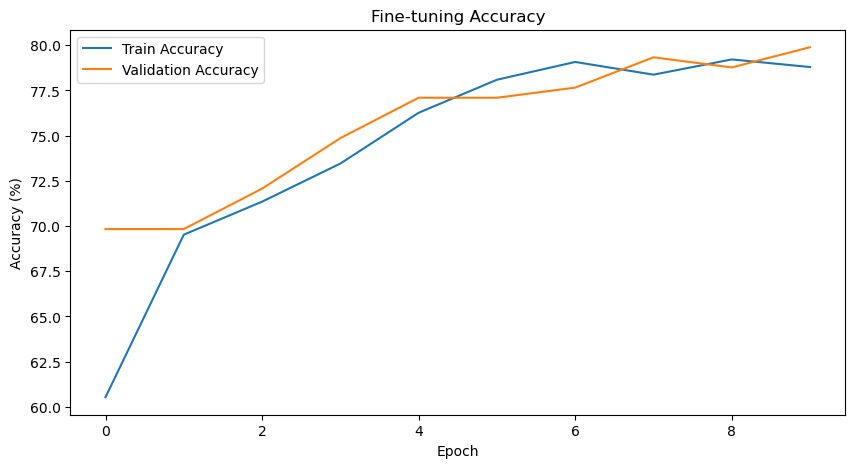

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

class TitanicDatasetWithLabels(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data.values.astype('float32'))
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def prepare_evaluation_data():
    # Load original data
    df = pd.read_csv('train.csv')

    # Get survival labels
    labels = df['Survived'].values

    # Process features (same as in training)
    df_processed, categorical_indices, numerical_indices = prepare_titanic_data(df)

    # Split data
    from sklearn.model_selection import train_test_split
    train_data, val_data, train_labels, val_labels = train_test_split(
        df_processed, labels, test_size=0.2, random_state=42
    )

    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_data.iloc[:, numerical_indices] = scaler.fit_transform(train_data.iloc[:, numerical_indices])
    val_data.iloc[:, numerical_indices] = scaler.transform(val_data.iloc[:, numerical_indices])

    # Create datasets
    train_dataset = TitanicDatasetWithLabels(train_data, train_labels)
    val_dataset = TitanicDatasetWithLabels(val_data, val_labels)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Get feature names
    feature_names = df_processed.columns.tolist()

    return train_loader, val_loader, train_dataset, val_dataset, feature_names

def evaluate_model(model, train_loader, val_loader, feature_names):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    def extract_features(dataloader):
        features = []
        labels = []
        model.eval()
        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(device)
                # Get features from encoder (before projection head)
                feature = model.encoder.encoder(x)
                features.append(feature.cpu())
                labels.append(y.cpu())

        features = torch.cat(features, dim=0)
        labels = torch.cat(labels, dim=0)
        return features.numpy(), labels.numpy()

    # Extract features
    print("Extracting features...")
    train_features, train_labels = extract_features(train_loader)
    val_features, val_labels = extract_features(val_loader)

    print(f"Feature shapes - Train: {train_features.shape}, Val: {val_features.shape}")

    # 1. Linear Probe Evaluation
    print("\nPerforming linear probe evaluation...")
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_features, train_labels)
    predictions = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, predictions)
    print("\nLinear Probe Classification Report:")
    print(classification_report(val_labels, predictions))

    # 2. t-SNE Visualization
    print("\nGenerating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(train_features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                          c=train_labels, cmap='viridis')
    plt.colorbar(scatter, label='Survival')
    plt.title('t-SNE Visualization of Learned Representations')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.savefig('tsne_visualization.png')
    plt.show()

    # 3. Feature Importance Analysis
    print("\nAnalyzing feature importance...")
    # Generate feature names for the encoded representation
    encoded_feature_names = [f'encoded_feature_{i}' for i in range(train_features.shape[1])]

    importances = np.abs(clf.coef_[0])
    feature_importance = pd.DataFrame({
        'feature': encoded_feature_names,
        'importance': importances
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Encoded Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    return accuracy, feature_importance
def analyze_original_features(model, train_loader, original_feature_names):
    """
    Analyze the contribution of original features through the encoder
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get the first layer weights of the encoder
    first_layer_weights = model.encoder.encoder[0].weight.detach().cpu().numpy()

    # Calculate feature importance as the L1 norm of the weights
    feature_importance = np.abs(first_layer_weights).mean(axis=0)

    # Create DataFrame with original feature names
    importance_df = pd.DataFrame({
        'feature': original_feature_names,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Plot original feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Original Features')
    plt.tight_layout()
    plt.savefig('original_feature_importance.png')
    plt.show()

    return importance_df

def fine_tune_for_survival(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create downstream classifier
    downstream_model = DownstreamClassifier(model.encoder)
    downstream_model = downstream_model.to(device)

    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(downstream_model.classifier.parameters(), lr=0.001)

    # Training loop
    best_accuracy = 0
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        downstream_model.train()
        train_correct = 0
        train_total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = downstream_model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            train_total += y.size(0)
            train_correct += predicted.eq(y).sum().item()

        train_accuracy = 100. * train_correct / train_total
        train_accuracies.append(train_accuracy)

        # Validation
        downstream_model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = downstream_model(x)
                _, predicted = outputs.max(1)
                val_total += y.size(0)
                val_correct += predicted.eq(y).sum().item()

        val_accuracy = 100. * val_correct / val_total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Acc = {train_accuracy:.2f}%, Val Acc = {val_accuracy:.2f}%')

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(downstream_model.state_dict(), 'best_downstream_model.pt')

    return train_accuracies, val_accuracies

# Usage example:
print("Preparing evaluation data...")
train_loader, val_loader, train_dataset, val_dataset, feature_names = prepare_evaluation_data()

print("\nEvaluating SimCLR model...")
accuracy, encoded_importance = evaluate_model(model, train_loader, val_loader, feature_names)
print(f"\nLinear probe accuracy: {accuracy:.4f}")
print("\nTop 10 most important encoded features:")
print(encoded_importance.head(10))

print("\nAnalyzing original feature importance...")
original_importance = analyze_original_features(model, train_loader, feature_names)
print("\nTop 10 most important original features:")
print(original_importance.head(10))

print("\nFine-tuning for survival prediction...")
train_acc, val_acc = fine_tune_for_survival(model, train_loader, val_loader)

# Plot fine-tuning results
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fine-tuning Accuracy')
plt.legend()
plt.savefig('fine_tuning_accuracy.png')
plt.show()

Creating data loaders...

Evaluating model...
Extracting features...

Performing linear probe evaluation...

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


Generating t-SNE visualization...


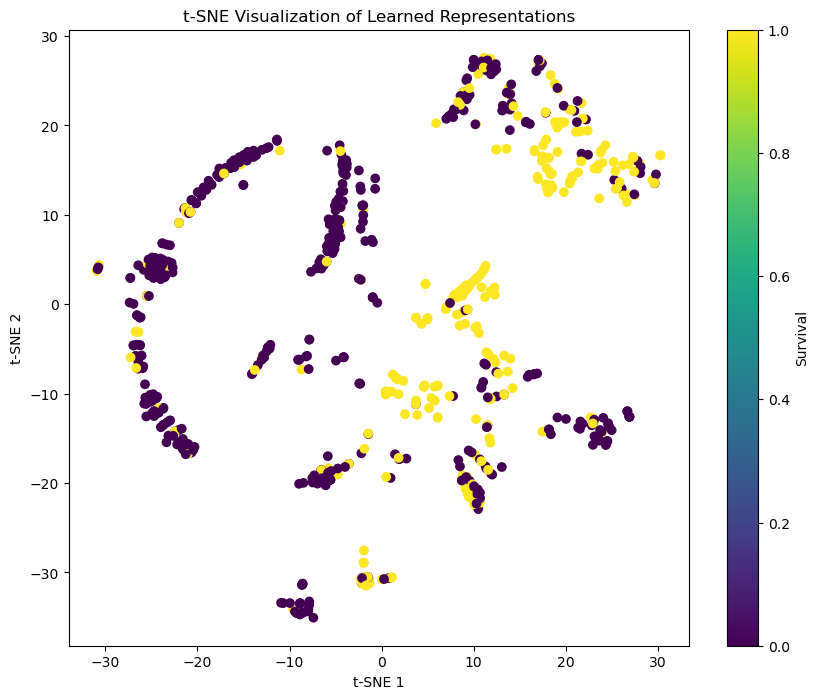


Analyzing feature importance...


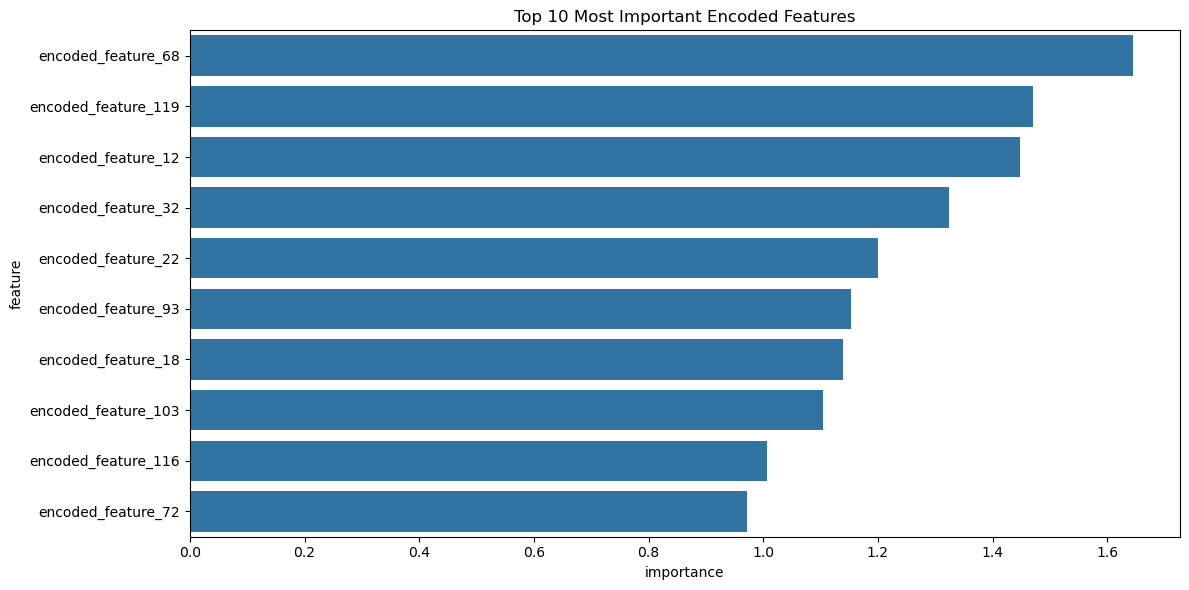


Linear probe accuracy: 0.7989

Top 10 most important encoded features:
                 feature  importance
68    encoded_feature_68    1.644667
119  encoded_feature_119    1.470676
12    encoded_feature_12    1.448355
32    encoded_feature_32    1.324251
22    encoded_feature_22    1.199894
93    encoded_feature_93    1.153463
18    encoded_feature_18    1.138301
103  encoded_feature_103    1.104824
116  encoded_feature_116    1.006489
72    encoded_feature_72    0.971642

Fine-tuning model...
Epoch 1: Train Acc = 51.26%, Val Acc = 62.57%
Epoch 2: Train Acc = 67.13%, Val Acc = 67.60%
Epoch 3: Train Acc = 71.49%, Val Acc = 72.07%
Epoch 4: Train Acc = 75.84%, Val Acc = 75.98%
Epoch 5: Train Acc = 77.39%, Val Acc = 75.98%
Epoch 6: Train Acc = 78.65%, Val Acc = 77.09%
Epoch 7: Train Acc = 79.49%, Val Acc = 77.65%
Epoch 8: Train Acc = 78.51%, Val Acc = 78.77%
Epoch 9: Train Acc = 79.21%, Val Acc = 79.33%
Epoch 10: Train Acc = 78.79%, Val Acc = 79.89%


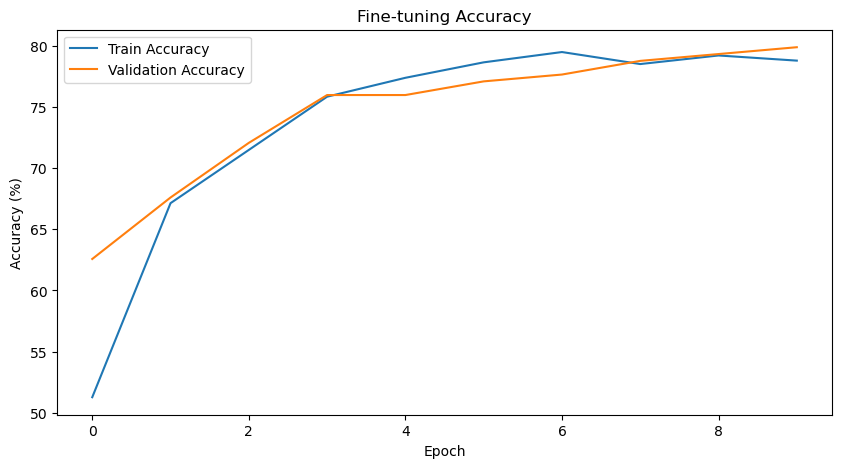

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

class TitanicDatasetWithLabels(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data.values.astype('float32'))
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def prepare_titanic_data(df):
    # Select relevant columns
    categorical_cols = ['Pclass', 'Sex', 'Embarked']
    numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
    
    # Create a copy of selected columns only
    df_selected = df[categorical_cols + numerical_cols].copy()
    
    # Handle missing values in numerical columns
    for col in numerical_cols:
        df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')
        df_selected[col] = df_selected[col].fillna(df_selected[col].mean())
    
    # Handle missing values in categorical columns
    for col in categorical_cols:
        df_selected[col] = df_selected[col].fillna(df_selected[col].mode()[0])
    
    # Convert categorical columns to one-hot
    df_encoded = pd.get_dummies(df_selected, columns=categorical_cols)
    
    # Get numerical and categorical indices
    numerical_indices = list(range(len(numerical_cols)))
    categorical_indices = list(range(len(numerical_cols), df_encoded.shape[1]))
    
    return df_encoded, categorical_indices, numerical_indices

def create_data_loaders(model_path=None):
    # Load data
    df = pd.read_csv('train.csv')
    
    # Get labels
    labels = df['Survived'].values
    
    # Process features
    df_processed, categorical_indices, numerical_indices = prepare_titanic_data(df)
    
    # Split data
    train_data, val_data, train_labels, val_labels = train_test_split(
        df_processed, labels, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    train_data.iloc[:, numerical_indices] = scaler.fit_transform(train_data.iloc[:, numerical_indices])
    val_data.iloc[:, numerical_indices] = scaler.transform(val_data.iloc[:, numerical_indices])
    
    # Create datasets
    train_dataset = TitanicDatasetWithLabels(train_data, train_labels)
    val_dataset = TitanicDatasetWithLabels(val_data, val_labels)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, train_dataset, val_dataset, df_processed.columns.tolist()

def evaluate_model(model, train_loader, val_loader, feature_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    def extract_features(dataloader):
        features = []
        labels = []
        model.eval()
        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(device)
                feature = model.encoder.encoder(x)
                features.append(feature.cpu())
                labels.append(y.cpu())
        
        features = torch.cat(features, dim=0)
        labels = torch.cat(labels, dim=0)
        return features.numpy(), labels.numpy()
    
    # Extract features
    print("Extracting features...")
    train_features, train_labels = extract_features(train_loader)
    val_features, val_labels = extract_features(val_loader)
    
    # Linear probe evaluation
    print("\nPerforming linear probe evaluation...")
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_features, train_labels)
    predictions = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, predictions)
    print("\nClassification Report:")
    print(classification_report(val_labels, predictions))
    
    # t-SNE visualization
    print("\nGenerating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(train_features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=train_labels, cmap='viridis')
    plt.colorbar(scatter, label='Survival')
    plt.title('t-SNE Visualization of Learned Representations')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.savefig('tsne_visualization.png')
    plt.show()
    
    # Feature importance analysis
    print("\nAnalyzing feature importance...")
    encoded_feature_names = [f'encoded_feature_{i}' for i in range(train_features.shape[1])]
    importances = np.abs(clf.coef_[0])
    feature_importance = pd.DataFrame({
        'feature': encoded_feature_names,
        'importance': importances
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Encoded Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    return accuracy, feature_importance

def fine_tune_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create classifier
    class Classifier(nn.Module):
        def __init__(self, encoder):
            super().__init__()
            self.encoder = encoder
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.fc = nn.Linear(128, 2)  # 128 is hidden_dim from encoder
        
        def forward(self, x):
            with torch.no_grad():
                features = self.encoder.encoder(x)
            return self.fc(features)
    
    classifier = Classifier(model.encoder).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.fc.parameters(), lr=0.001)
    
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training
        classifier.train()
        correct = 0
        total = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = classifier(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
        
        train_acc = 100. * correct / total
        train_accs.append(train_acc)
        
        # Validation
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = classifier(x)
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()
        
        val_acc = 100. * correct / total
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%')
    
    return train_accs, val_accs

# Main execution
print("Creating data loaders...")
train_loader, val_loader, train_dataset, val_dataset, feature_names = create_data_loaders()

print("\nEvaluating model...")
accuracy, feature_importance = evaluate_model(model, train_loader, val_loader, feature_names)
print(f"\nLinear probe accuracy: {accuracy:.4f}")
print("\nTop 10 most important encoded features:")
print(feature_importance.head(10))

print("\nFine-tuning model...")
train_accs, val_accs = fine_tune_model(model, train_loader, val_loader)

# Plot fine-tuning results
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fine-tuning Accuracy')
plt.legend()
plt.savefig('fine_tuning_accuracy.png')
plt.show()

In [38]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class TestClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        # Freeze the encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add classification head
        self.classifier = nn.Linear(128, 2)  # 128 is hidden_dim from encoder

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder.encoder(x)
        return self.classifier(features)

def prepare_test_data():
    # Load train data (needed for scaling parameters)
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print("Train shape:", train_df.shape)
    print("Test shape:", test_df.shape)

    # Process both datasets
    categorical_cols = ['Pclass', 'Sex', 'Embarked']
    numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    # Process train data first to get scaling parameters
    train_selected = train_df[categorical_cols + numerical_cols].copy()

    # Get scaling parameters from train data
    scaling_params = {}
    for col in numerical_cols:
        scaling_params[col + '_mean'] = train_selected[col].mean()
        scaling_params[col + '_std'] = train_selected[col].std()

    # Process test data
    test_selected = test_df[categorical_cols + numerical_cols].copy()

    # Handle missing values in numerical columns
    for col in numerical_cols:
        test_selected[col] = pd.to_numeric(test_selected[col], errors='coerce')
        # Use train mean for filling NA
        test_selected[col] = test_selected[col].fillna(scaling_params[col + '_mean'])

    # Handle missing values in categorical columns
    for col in categorical_cols:
        test_selected[col] = test_selected[col].fillna(train_selected[col].mode()[0])

    # Convert categorical columns to one-hot
    test_encoded = pd.get_dummies(test_selected, columns=categorical_cols)

    # Make sure test has same columns as train
    train_encoded = pd.get_dummies(train_selected, columns=categorical_cols)
    for col in train_encoded.columns:
        if col not in test_encoded.columns:
            test_encoded[col] = 0
    test_encoded = test_encoded[train_encoded.columns]

    # Scale numerical features
    for col in numerical_cols:
        test_encoded[col] = (test_encoded[col] - scaling_params[col + '_mean']) / scaling_params[col + '_std']

    return test_encoded, test_df['PassengerId']

def predict_test_set(classifier_model, test_loader, device):
    classifier_model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for x in test_loader:
            x = x.to(device)
            # Get predictions through classifier
            outputs = classifier_model(x)
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            # Get predictions
            _, preds = outputs.max(1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return np.array(predictions), np.array(probabilities)

def create_submission(passenger_ids, predictions, probabilities, filename='submission.csv'):
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': predictions
    })
    # Save full submission with just required columns
    submission[['PassengerId', 'Survived']].to_csv(filename, index=False)

    # Save detailed submission with probabilities for analysis
    detailed_submission = submission.copy()
    detailed_submission['Survival_Probability'] = probabilities[:, 1]
    detailed_submission.to_csv('detailed_' + filename, index=False)

    return detailed_submission

def analyze_predictions(predictions, probabilities):
    # Distribution of predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=predictions)
    plt.title('Distribution of Predictions')
    plt.xlabel('Survived')
    plt.ylabel('Count')

    # Distribution of probabilities
    plt.subplot(1, 2, 2)
    sns.histplot(probabilities[:, 1], bins=30)
    plt.title('Distribution of Survival Probabilities')
    plt.xlabel('Probability of Survival')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('test_predictions_analysis.png')
    plt.close()

    # Print summary statistics
    print("\nPrediction Statistics:")
    print(f"Survival Rate: {predictions.mean():.3f}")
    print("\nProbability Statistics:")
    print(pd.Series(probabilities[:, 1]).describe())

# Main execution
def test_model(model, output_file='submission.csv'):
    print("Preparing test data...")
    test_data, passenger_ids = prepare_test_data()
    test_dataset = TitanicDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Create classifier model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classifier = TestClassifier(model.encoder)

    # Load the trained classifier weights
    try:
        classifier.load_state_dict(torch.load('best_downstream_model.pt'))
        print("Loaded trained classifier weights")
    except:
        print("Could not load classifier weights. Please make sure you've trained the model first!")
        return

    classifier = classifier.to(device)

    # Get predictions
    print("\nMaking predictions...")
    predictions, probabilities = predict_test_set(classifier, test_loader, device)

    # Create submission file
    print("\nCreating submission file...")
    submission = create_submission(passenger_ids, predictions, probabilities, output_file)
    print(f"Submission file created: {output_file}")

    # Analyze predictions
    print("\nAnalyzing predictions...")
    analyze_predictions(predictions, probabilities)

    # Print sample of predictions
    print("\nSample of predictions:")
    sample_df = pd.DataFrame({
        'PassengerId': passenger_ids[:10],
        'Predicted': predictions[:10],
        'Survival_Probability': probabilities[:10, 1]
    })
    print(sample_df)

    return submission

# Run the test
submission = test_model(model)

Preparing test data...
Train shape: (891, 12)
Test shape: (418, 11)
Dataset tensor shape: torch.Size([418, 12])
Loaded trained classifier weights

Making predictions...

Creating submission file...
Submission file created: submission.csv

Analyzing predictions...

Prediction Statistics:
Survival Rate: 0.294

Probability Statistics:
count    418.000000
mean       0.396091
std        0.190669
min        0.092579
25%        0.222093
50%        0.362389
75%        0.539782
max        0.965621
dtype: float64

Sample of predictions:
   PassengerId  Predicted  Survival_Probability
0          892          0              0.189328
1          893          0              0.384409
2          894          0              0.227638
3          895          0              0.195272
4          896          0              0.468071
5          897          0              0.249260
6          898          0              0.411897
7          899          0              0.320302
8          900          1          

Creating data loaders...

Starting experiments...

Training model with Large (128-64)


Training Large (128-64): 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]



Training model with Medium (32-16)


Training Medium (32-16): 100%|██████████| 50/50 [00:08<00:00,  5.64it/s]



Training model with Small (16-8)


Training Small (16-8): 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]



Training model with Tiny (8-4)


Training Tiny (8-4): 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


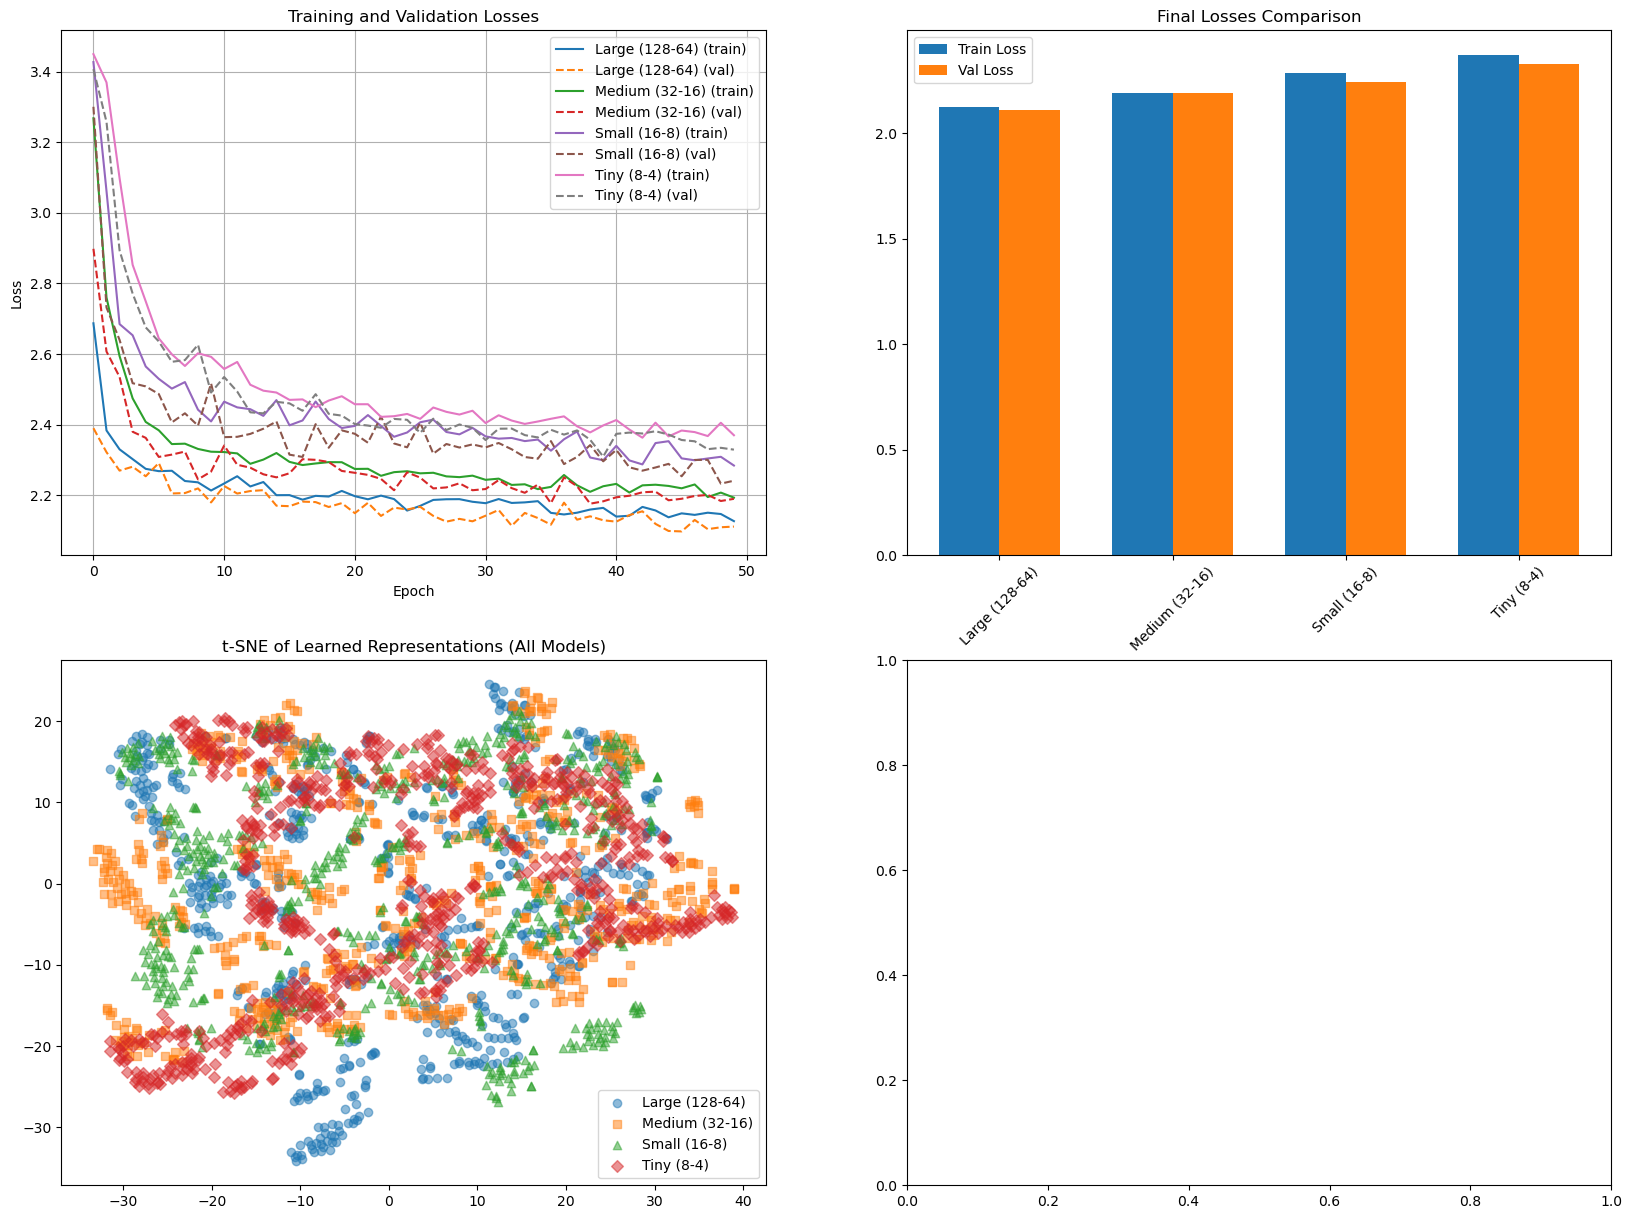

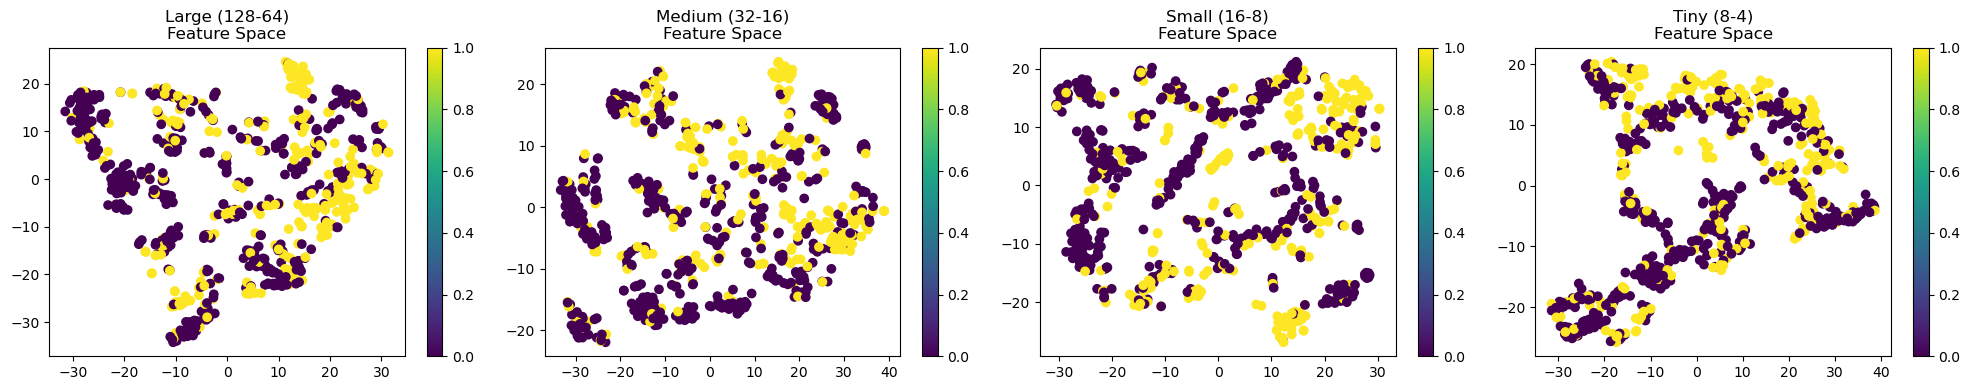


Summary Statistics:

Final Losses:
 Configuration  Final Train Loss  Final Val Loss  Hidden Dim  Projection Dim
Large (128-64)          2.126595        2.111214         128              64
Medium (32-16)          2.193151        2.189805          32              16
  Small (16-8)          2.284120        2.241145          16               8
    Tiny (8-4)          2.369941        2.329124           8               4

Feature Space Statistics:

Large (128-64):
Feature space dimension: 128
Mean activation: 0.1101
Std activation: 0.2421
Sparsity (% of zeros): 60.57%

Medium (32-16):
Feature space dimension: 32
Mean activation: 0.1218
Std activation: 0.2234
Sparsity (% of zeros): 49.86%

Small (16-8):
Feature space dimension: 16
Mean activation: 0.2261
Std activation: 0.2614
Sparsity (% of zeros): 28.41%

Tiny (8-4):
Feature space dimension: 8
Mean activation: 0.2921
Std activation: 0.3716
Sparsity (% of zeros): 28.93%


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from tqdm import tqdm

class TitanicDatasetWithLabels(Dataset):
    def __init__(self, data, labels=None):
        # Ensure data is float32
        self.data = torch.FloatTensor(data.values.astype('float32'))
        if labels is not None:
            self.labels = torch.LongTensor(labels)
        else:
            self.labels = None
        self.augmentation = TabularAugmentation(
            categorical_cols=list(range(4)),  # Adjust based on your actual data
            numerical_cols=list(range(4, len(data.columns)))  # Adjust based on your actual data
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.augmentation:
            x_i, x_j = self.augmentation(x)
            if self.labels is not None:
                return x_i.float(), x_j.float(), self.labels[idx]
            return x_i.float(), x_j.float()
        if self.labels is not None:
            return x.float(), self.labels[idx]
        return x.float()

def create_data_loaders(batch_size=32):
    # Load and preprocess data
    df = pd.read_csv('train.csv')
    df_processed, categorical_indices, numerical_indices = prepare_titanic_data(df)
    labels = df['Survived'].values

    # Split data
    train_data, val_data, train_labels, val_labels = train_test_split(
        df_processed, labels, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    train_data.iloc[:, numerical_indices] = scaler.fit_transform(train_data.iloc[:, numerical_indices])
    val_data.iloc[:, numerical_indices] = scaler.transform(val_data.iloc[:, numerical_indices])

    # Create datasets
    train_dataset = TitanicDatasetWithLabels(train_data, train_labels)
    val_dataset = TitanicDatasetWithLabels(val_data, val_labels)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, df_processed.shape[1]

class DimensionExperiment:
    def __init__(self, input_dim, configs, train_loader, val_loader, device):
        self.configs = configs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.input_dim = input_dim
        self.results = {}

    def train_model(self, config, num_epochs=50):
        encoder = Encoder(
            input_dim=self.input_dim,
            hidden_dim=config.hidden_dim,
            projection_dim=config.projection_dim
        ).to(self.device)

        model = SimCLR(encoder).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_losses = []

        for epoch in tqdm(range(num_epochs), desc=f"Training {config.name}"):
            # Training
            model.train()
            epoch_loss = 0
            for x_i, x_j, _ in self.train_loader:
                x_i, x_j = x_i.to(self.device), x_j.to(self.device)
                loss = model(x_i, x_j)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(self.train_loader))

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x_i, x_j, _ in self.val_loader:
                    x_i, x_j = x_i.to(self.device), x_j.to(self.device)
                    loss = model(x_i, x_j)
                    val_loss += loss.item()
            val_losses.append(val_loss / len(self.val_loader))

        return model, train_losses, val_losses

    def extract_features(self, model, loader):
        features = []
        labels = []
        model.eval()
        with torch.no_grad():
            for x_i, x_j, y in loader:
                x = x_i.to(self.device)  # Use first augmented view
                feature = model.encoder.encoder(x)
                features.append(feature.cpu())
                labels.append(y)

        features = torch.cat(features, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()
        return features, labels

    def run_experiments(self):
        for config in self.configs:
            print(f"\nTraining model with {config.name}")
            model, train_losses, val_losses = self.train_model(config)

            # Extract features
            train_features, train_labels = self.extract_features(model, self.train_loader)

            # Store results
            self.results[config.name] = {
                'model': model,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'features': train_features,
                'labels': train_labels,
                'config': config
            }

    def plot_results(self):
        plt.figure(figsize=(20, 15))

        # 1. Training Losses
        plt.subplot(2, 2, 1)
        for name, result in self.results.items():
            plt.plot(result['train_losses'], label=f'{name} (train)')
            plt.plot(result['val_losses'], '--', label=f'{name} (val)')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # 2. Final Loss Comparison
        plt.subplot(2, 2, 2)
        names = list(self.results.keys())
        final_train_losses = [result['train_losses'][-1] for result in self.results.values()]
        final_val_losses = [result['val_losses'][-1] for result in self.results.values()]

        x = np.arange(len(names))
        width = 0.35

        plt.bar(x - width/2, final_train_losses, width, label='Train Loss')
        plt.bar(x + width/2, final_val_losses, width, label='Val Loss')
        plt.xticks(x, names, rotation=45)
        plt.title('Final Losses Comparison')
        plt.legend()

        # 3. Feature Space Visualization (t-SNE) - All models in one plot
        plt.subplot(2, 2, 3)
        markers = ['o', 's', '^', 'D', 'v']  # Different markers for different models
        for (name, result), marker in zip(self.results.items(), markers):
            tsne = TSNE(n_components=2, random_state=42)
            features_2d = tsne.fit_transform(result['features'])
            scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                                  marker=marker, alpha=0.5, label=name)
        plt.title('t-SNE of Learned Representations (All Models)')
        plt.legend()

        # 4. Individual t-SNE plots
        num_models = len(self.results)
        plt.subplot(2, 2, 4)
        fig_individual, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4))
        for (name, result), ax in zip(self.results.items(), axes):
            tsne = TSNE(n_components=2, random_state=42)
            features_2d = tsne.fit_transform(result['features'])
            scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1],
                                 c=result['labels'], cmap='viridis')
            ax.set_title(f'{name}\nFeature Space')
            fig_individual.colorbar(scatter, ax=ax)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary Statistics:")
        print("\nFinal Losses:")
        stats_df = pd.DataFrame({
            'Configuration': names,
            'Final Train Loss': final_train_losses,
            'Final Val Loss': final_val_losses,
            'Hidden Dim': [result['config'].hidden_dim for result in self.results.values()],
            'Projection Dim': [result['config'].projection_dim for result in self.results.values()]
        })
        print(stats_df.to_string(index=False))

        # Calculate and print feature space statistics
        print("\nFeature Space Statistics:")
        for name, result in self.results.items():
            features = result['features']
            print(f"\n{name}:")
            print(f"Feature space dimension: {features.shape[1]}")
            print(f"Mean activation: {np.mean(features):.4f}")
            print(f"Std activation: {np.std(features):.4f}")
            print(f"Sparsity (% of zeros): {(features == 0).mean() * 100:.2f}%")

    def plot_feature_correlations(self):
        """Plot feature correlation matrices for each model"""
        fig, axes = plt.subplots(1, len(self.results),
                                 figsize=(6*len(self.results), 5))
        if len(self.results) == 1:
            axes = [axes]

        for (name, result), ax in zip(self.results.items(), axes):
            features = result['features']
            corr = np.corrcoef(features.T)
            sns.heatmap(corr, ax=ax, cmap='coolwarm', center=0,
                        square=True, cbar=True)
            ax.set_title(f'{name}\nFeature Correlations')

        plt.tight_layout()
        plt.show()

    def plot_feature_distributions(self):
        """Plot distribution of feature activations for each model"""
        for name, result in self.results.items():
            features = result['features']
            n_features = features.shape[1]

            fig, axes = plt.subplots(1, 1, figsize=(12, 6))
            for i in range(n_features):
                sns.kdeplot(features[:, i], label=f'Feature {i}', ax=axes)

            plt.title(f'{name}\nFeature Activation Distributions')
            plt.xlabel('Activation Value')
            plt.ylabel('Density')
            if n_features <= 10:  # Only show legend if not too many features
                plt.legend()
            plt.show()

class EncoderConfig:
    def __init__(self, hidden_dim, projection_dim, name):
        self.hidden_dim = hidden_dim
        self.projection_dim = projection_dim
        self.name = name

# Run the experiment
print("Creating data loaders...")
train_loader, val_loader, input_dim = create_data_loaders()

# Define configurations to test
configs = [
    EncoderConfig(hidden_dim=128, projection_dim=64, name='Large (128-64)'),
    EncoderConfig(hidden_dim=32, projection_dim=16, name='Medium (32-16)'),
    EncoderConfig(hidden_dim=16, projection_dim=8, name='Small (16-8)'),
    EncoderConfig(hidden_dim=8, projection_dim=4, name='Tiny (8-4)')
]

# Create and run experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
experiment = DimensionExperiment(
    input_dim=input_dim,
    configs=configs,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

# Run experiments
print("\nStarting experiments...")
experiment.run_experiments()
experiment.plot_results()

In [39]:
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super().__init__()
        self.encoder = encoder
        # Freeze the encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add classification head
        self.classifier = nn.Linear(128, num_classes)  # 128 is hidden_dim from encoder

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder.encoder(x)  # Use only encoder part, not projection head
        return self.classifier(features)

def extract_features(model, dataloader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            feature = model.encoder(x)
            features.append(feature.cpu())
            if len(batch) > 1:  # If labels are available
                labels.append(batch[1].cpu())

    features = torch.cat(features, dim=0)
    if labels:
        labels = torch.cat(labels, dim=0)
        return features.numpy(), labels.numpy()
    return features.numpy()

def evaluate_representations():
    # 1. Linear Probe Evaluation
    def linear_probe_evaluation(train_features, train_labels, test_features, test_labels):
        clf = LogisticRegression(max_iter=1000)
        clf.fit(train_features, train_labels)
        predictions = clf.predict(test_features)
        accuracy = accuracy_score(test_labels, predictions)
        print("\nLinear Probe Classification Report:")
        print(classification_report(test_labels, predictions))
        return accuracy, clf

    # 2. Visualization of Learned Representations
    def visualize_representations(features, labels):
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        features_2d = tsne.fit_transform(features)

        # Create scatter plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter)
        plt.title('t-SNE Visualization of Learned Representations')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.savefig('tsne_visualization.png')
        plt.close()

    # 3. Feature Importance Analysis
    def analyze_feature_importance(clf, feature_names):
        importances = np.abs(clf.coef_[0])
        feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features')
        plt.savefig('feature_importance.png')
        plt.close()

        return feature_importance

    # Example usage
    # Prepare data for downstream task (e.g., survival prediction)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Extract features
    train_features, train_labels = extract_features(model, train_loader, device)
    val_features, val_labels = extract_features(model, val_loader, device)

    # Evaluate with linear probe
    accuracy, clf = linear_probe_evaluation(train_features, train_labels, val_features, val_labels)
    print(f"\nLinear probe accuracy: {accuracy:.4f}")

    # Visualize representations
    visualize_representations(train_features, train_labels)

    # Analyze feature importance
    feature_importance = analyze_feature_importance(clf, feature_names)
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

def fine_tune_downstream():
    # Create downstream classifier
    downstream_model = DownstreamClassifier(model.encoder)
    downstream_model = downstream_model.to(device)

    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(downstream_model.classifier.parameters(), lr=0.001)

    num_epochs = 100
    # Training loop
    downstream_model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            x, y = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            outputs = downstream_model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        accuracy = 100. * correct / total
        print(f'Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Accuracy = {accuracy:.2f}%')

# Function to plot training curves
def plot_training_metrics(train_losses, val_losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()

In [42]:
# 1. First evaluate the representations
#evaluate_representations()

# 2. Fine-tune for downstream task
#fine_tune_downstream()

# 3. Plot training metrics
#plot_training_metrics(train_losses, val_losses)


Linear Probe Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Linear probe accuracy: 0.8045


ValueError: All arrays must be of the same length